In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

C:\Programme\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Erklärung des Beispiels
Wir wollen unser erstes Beispiel programmieren und da wir die ganze Zeit von einer Achterbahn geredet haben, werden wir diese jetzt in TensorFlow realisieren. Zugegeben eine äußerst stark vereinfachte Variante, aber für das Verständnis vollkommen ausreichend!

Wie im oberen Teil beschrieben, unterteilt sich die Arbeit mit TensorFlow in zwei Phasen:
 1. Erstellung des Graphen: In unserem Falle wäre das die Konstruktion unserer Achterbahn
 2. Ausführung des Graphen: in dieser Phase lassen wir unsere Insassen einfach los und schauen mal was passiert
 
Um die Zahlen zu verstehen, möchte ich euch zudem erklären, was überhaupt das Ziel unseres Modells ist. Wir haben 8 Probanden mit verschiedenen Angstzuständen. Je größer dieser Wert ist, desto ängstlicher sind unsere Probanden. Unser Ziel ist es alle Probanden, welche einen Angstzustand >5 haben, nach der Fahrt unserer Achterbahn den Wunsch verspüren nie mitgefahren zu sein! Die Größe die wir dabei optimieren wollen, ist die Geschwindigkeit. Wenn die Geschwindigkeit zu schnell ist, dann fürchten sich zu viele, wenn wir zu langsam fahren, dann fürchtet sich womöglich niemand. 

__Wir suchen also die passende Geschwindigkeit um unser Ziel Angstzustand > 5 => Wunsch nie mitgefahren zu sein.__

Unser Szenario ist also eine Klassifikationsaufgabe!


## Eingangssignale: Zustände der Gäste 
Wir sehen hier zwei Vektoren bzw. Tensoren die Informationen über unsere Gäste haben. 
 * `x_input` ist der Angstzustand unserer Gäste
 * `y_input` ist unser gewünschtes Ausgangsssignal: 0 $\rightarrow$ normal, 1 $\rightarrow$ Wunsch nicht mitgefahren zu sein

In [2]:
# Eingangssignale, Tensor
# Zustand der Gäste -> je  größer die Zahl desto größer der Angstzustand der Gäste
x_input = [[-10], # <- Angstzustand Gast 1
           [-5],  # <- Angstzustand Gast 2
           [-2],  # <- Angstzustand Gast 3
           [-1],
           [2],
           [1],
           [6],
           [9]]   # <- Angstzustand Gast 8

# gewünschtes Ausgangssignal, Tensor
# Endzustand der Gäste -> Wunsch die Bahn nie gefahren zu sein
y_input = [[0], 
           [0],
           [0],
           [0],
           [0],
           [0],
           [1], # <- bereut die Fahrt
           [1]] # <- bereut die Fahrt

## Erstellung unseres Graphen: Konstruktion der Achterbahn
Nun konstruieren wir unsere Achterbahn des Grauens: 

Eine undichte Gleichrichter-Aktivierungsfunktion (engl. leaky rectifier) mit einer Matrizenmultiplikation aus einem Vektor und einem Skalar mit anschließender Fehleroptimierung der ... MUHAHAHAHAHAHA. 

In [3]:
# Platzhalter
    # Wagon, Eingangsgröße
wag = tf.placeholder(tf.float32, shape = [8, 1])
    # gewünschter Endzustand der Gäste
y_true = tf.placeholder(tf.float32, shape = [8, 1]) 

# Variable 
    # Geschwindigkeit des Wagons
v = tf.Variable([[1.0,]]) #tf.random_normal(shape=[1,1], mean=2, stddev=1)
    # Starthöhe des Wagons
h = tf.Variable([[-2.0]]) #tf.random_normal(shape=[1,1])

# Knoten mit Matrizenoperator, Fahrelement, z.B. Airtime-Hügel
z = tf.matmul(wag, v) + h
# Knoten mit ReLu-Aktivierungsfunktion
y_pred = tf.nn.relu(z)
# Fehlerfunktion
err = tf.square(y_true - y_pred)
# Optimierer
opt = tf.train.AdamOptimizer(learning_rate=0.01).minimize(err)
# Initialisierung der Variablen (Geschwindigkeit)
init = tf.global_variables_initializer()

Auf den ersten Blick vielleicht ein wenig verwirrend, deshalb wollen wir alles Schritt für Schritt durchgehen:

 * `wag` ist unser Wagon, welcher die Achterbahn auf und ab fährt. Gefühlt mit unseren Probanden. Da diese Größen aus unseren externen Daten ausgezogen werden, liegt diese Größe als Platzhalter vor.
     - Wichtig bei __[Platzhalter](https://www.tensorflow.org/api_docs/python/tf/placeholder)__ ist, dass ihr den Datentyp angeben müsst!
     - Optional könnt ihr auch die Form angeben. Bei einem so überschaubaren Beispiel machen wir das auch.
 * `ziel, y_true` ist der Endzustand unserer Gäste, den wir uns für die Probanden erhoffen, d.h. es ist unser `y_input`. Auch hier kommen die Daten von außerhalb und daher wird der Platzhalter genutzt.
 * `v` ist unsere Geschwindigkeit und da diese optimiert werden muss, liegt sie als Variable vor
     - Wie ihr seht ist in der __[Variable](https://www.tensorflow.org/api_docs/python/tf/Variable)__ noch eine weitere __[Funktion](https://www.tensorflow.org/api_docs/python/tf/random_normal)__, welche uns eine zufällige Zahl ausgibt (ihr könnt auch eine Zahl eingeben, aber wir sind faul und lassen daher den Zufall entscheiden)

Nun zum zweiten Teil der Modellierung in dem wir ein klein wenig Mathematik benötigen. Schauen wir uns folgende Gleichung an:

* `tf.matmul(wag, v)`: ist unsere Matrizenmultiplikation -> Da unsere Größen in Vektoren/Tensoren vorliegen, können wir diese nicht einfach multiplizieren, wie z.B. 2*2 = 4. Bei der Multiplikation von Matrizen oder Vektoren müssen bestimmte Bedingungen herrschen, damit diese überhaupt multipliziert werden können. Für ausführlichere Erklärungen, schreibt es einfach in die Kommentare.
* `tf.nn.relu(z)`: Für all diejenigen, die sich bereits mit neuronalen Netzen beschäftigt haben; leaky_relu ist in unserem Fall die Aktivierungsfunktion. Für alle anderen, die mit der Aktivierungsfunktion noch nichts anfangen können: Die Kombination (Matrizenmultiplikation) aus dem Angstzustand und der Geschwindigkeit erreicht den Wert $Z$. Je nachdem welche Aktivierungsfunktion haben triggert dieser Wert $Z$ unsere Emotionen, so dass wir den Wunsch verspüren, die Bahn nie gefahren zu haben. 


## Ausführung des Graphen: Test der Achterbahn

In [10]:
# Rundenanzahl 
runden = 100
# Array zum notieren der Größen
v_array = []
h_array = []
# Aufzeichnung des Fehlerwertes
loss = []
    
# Ausführung des Graphen
with tf.Session() as sess:
    # Initialisierung dar Variablen
    sess.run(init)
    # Beginn der 100 Fahrten
    for i in range(runden):
        # Ausgabe der Werte
        _, geschw ,hoehe ,Y_pred , error = sess.run([opt,v,h , y_pred, err], 
                                                    feed_dict = {wag:x_input, 
                                                                 y_true:y_input
                                                                }
                                                   )
        loss.append(np.mean(error))
        v_array.append(float(geschw))
        h_array.append(float(hoehe))

# Ausgabe der letzten Werte 
print('Angstlvl berechnet: \n{}'.format(Y_pred))
print('\n Geschwindigkeit: \n{}'.format(geschw))
print('\n Starthöhe: \n{}'.format(hoehe))
print('\n Fehler: \n{}'.format(error))

Angstlvl berechnet: 
[[0.       ]
 [0.       ]
 [0.       ]
 [0.       ]
 [0.       ]
 [0.       ]
 [0.206007 ]
 [1.5684612]]

 Geschwindigkeit: 
[[0.4536385]]

 Starthöhe: 
[[-2.5187473]]

 Fehler: 
[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.63042486]
 [0.3231481 ]]


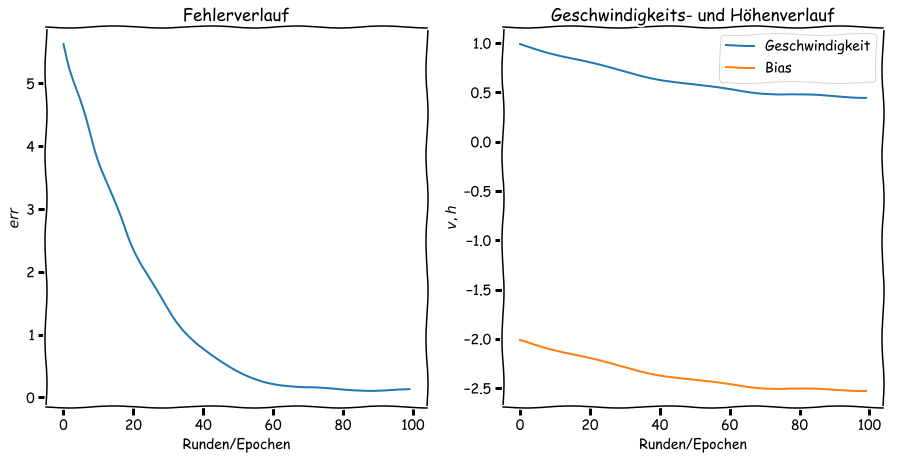

In [7]:
with plt.xkcd():
    fig, ax = plt.subplots(1,2, figsize=(15, 7))
    ax[0].plot(range(runden), loss)
    ax[0].set_xlabel('Runden/Epochen')
    ax[0].set_ylabel('$err$')
    ax[0].title.set_text('Fehlerverlauf')
    ax[1].plot(range(runden), v_array, label='Geschwindigkeit')
    ax[1].plot(range(runden), h_array, label='Bias')
    ax[1].set_xlabel('Runden/Epochen')
    ax[1].set_ylabel('$v, h$')
    ax[1].legend()
    ax[1].title.set_text('Geschwindigkeits- und Höhenverlauf')
plt.savefig('achterbahn_result.png')